# HSE 2025: Mathematical Methods for Data Analysis

## Seminar 10: Anomaly Detection & Clustering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
import warnings
warnings.filterwarnings("ignore")

# Outline

## Anomaly Detection
- [One-class SVM](#one-class_svm)
- [Isolation Forest](#isolation_forest)
- [CUSUM](#cumsum)

## Clustering
- [k-means](#k-means)
- [DBSCAN](#dbscan)
- [Hierarchical clustering](#Hierarchical-clustering)

## Data preparation & EDA

In [ ]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
#data = pd.read_csv('winequality-white.csv', sep=';')
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

In [ ]:
data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991723   
50%       0.043000            34.000000            134.000000     0.993740   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188267     0.489847    10.514267     5.877909  
std       0.151001     0.114126     1.230621     0.885639  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.470000    10.400000     6.000000  
75%       3.280000     0.550000    11.400000     6.000000  
max       3.820000     1.080000    14.200000     9.000000

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

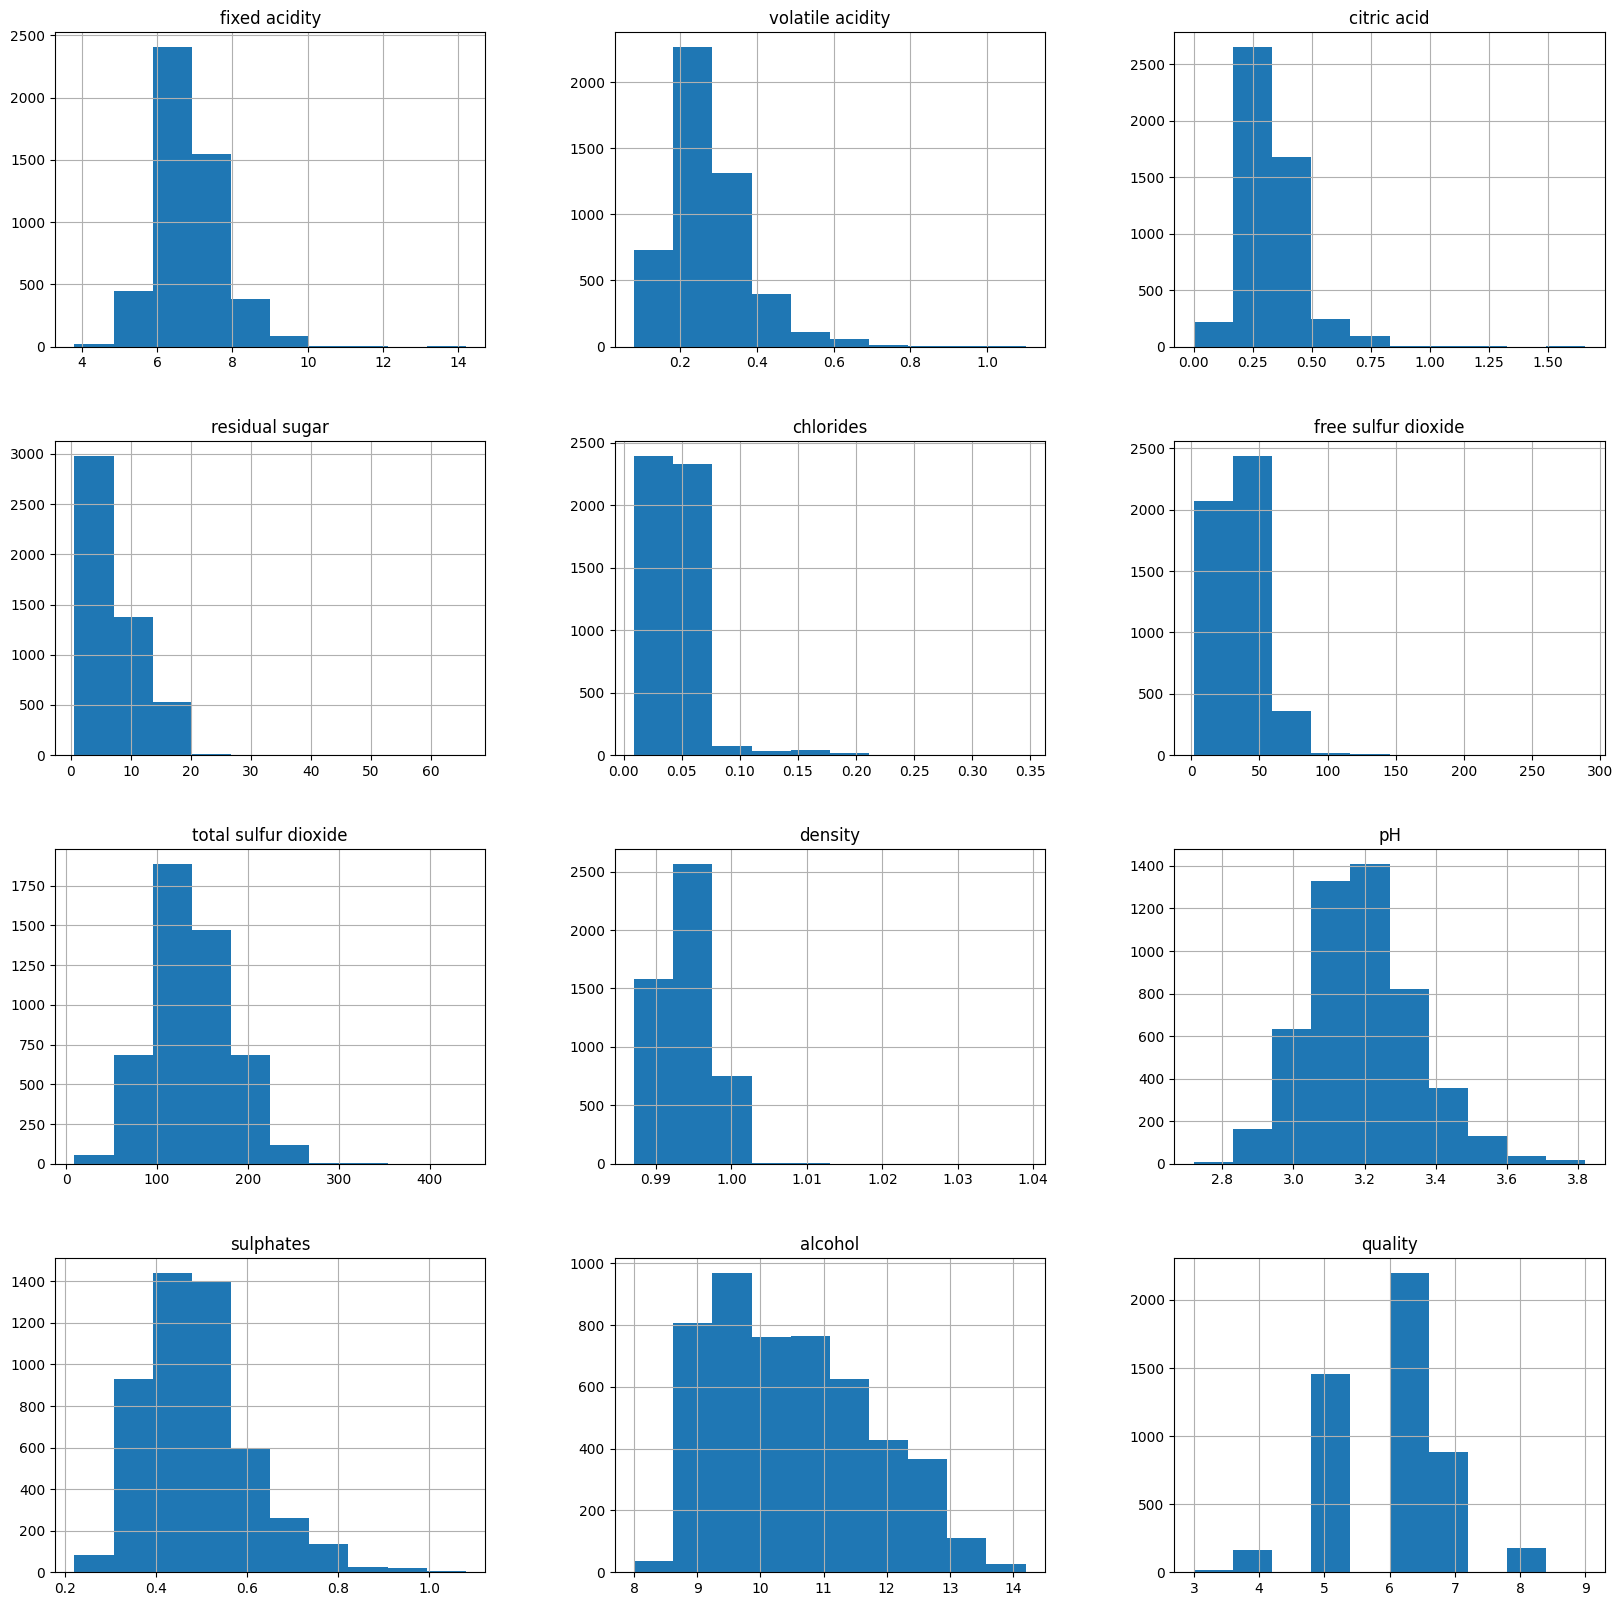

In [ ]:
data.hist(figsize=(20, 20))

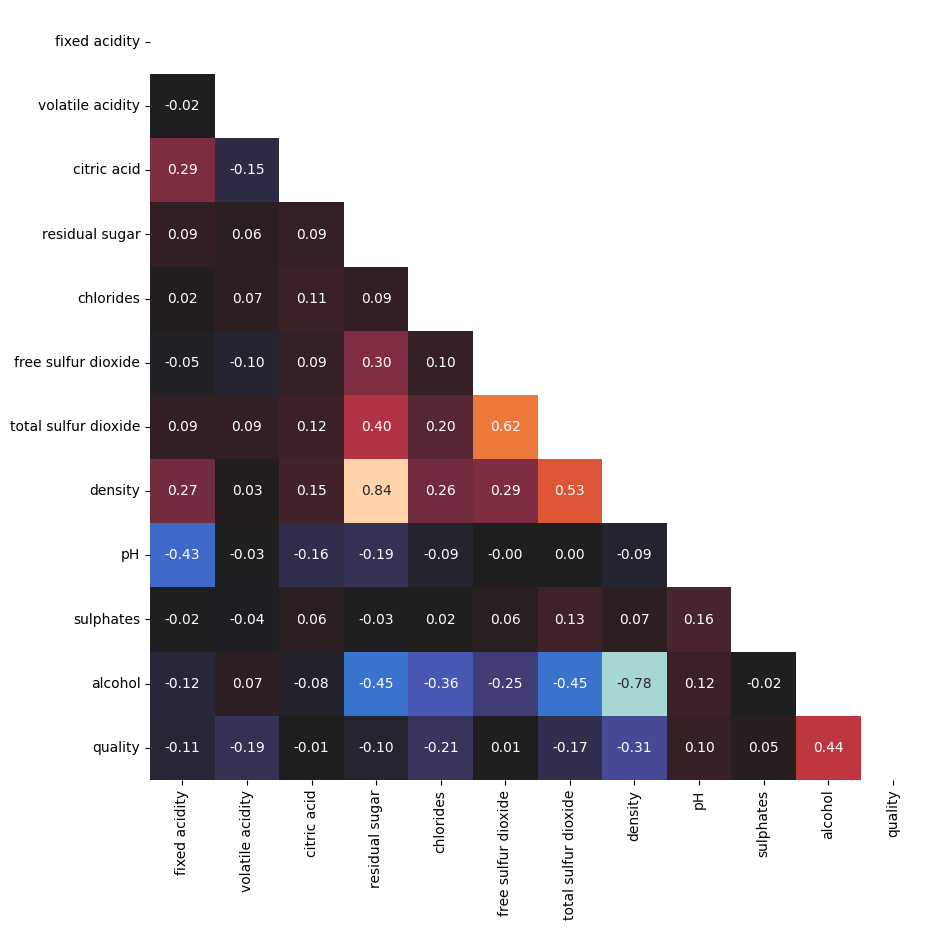

In [ ]:
plt.figure(figsize=(10,10))

corr_matrix = data.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

In [ ]:
high_corr = [
    column for column in lower.columns if any((lower[column] > 0.6)|(lower[column] < -0.6))
]
high_corr

['residual sugar', 'free sulfur dioxide', 'density']

In [ ]:
other_features = [col for col in data.columns if col not in high_corr and col!='quality']

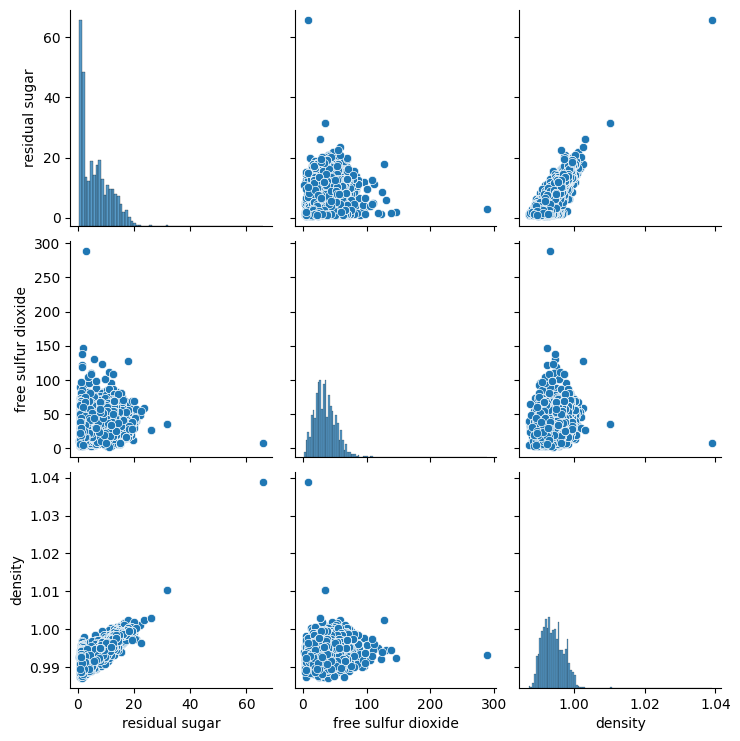

In [ ]:
sns.pairplot(data[high_corr]);

## The Simple method

### 3-$\sigma$

In [ ]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = (data[col] > up_bound) | (data[col] < low_bound)  # Create boolean mask directly
    return anomalies, up_bound, low_bound

In [ ]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns

    outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')  # Use data.index
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]

        # Use boolean indexing with .loc
        outliers.loc[data.index[anomalies]] = True

    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    comparison_table = comparison_table.sort_values(by='anomalies_percentage', ascending=False)

    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))

In [ ]:
data_features = data.iloc[:, :-1]

In [ ]:
comparison_table, std_outliers = get_column_outliers(data_features)
anomalies_report(std_outliers)

Total number of outliers: 396
Percentage of outliers:   8.08%


In [ ]:
comparison_table

upper_bound  lower_bound  anomalies_count  \
chlorides                0.111316    -0.019772            102.0   
citric acid              0.697251    -0.028868             85.0   
volatile acidity         0.580625    -0.024143             81.0   
sulphates                0.832224     0.147469             48.0   
fixed acidity            9.386392     4.323183             46.0   
free sulfur dioxide     86.329497   -15.713327             32.0   
pH                       3.641268     2.735265             32.0   
total sulfur dioxide   265.854851    10.866464             12.0   
residual sugar          21.607588    -8.824758              9.0   
density                  1.003000     0.985055              3.0   
alcohol                 14.206129     6.822405              0.0   

                      anomalies_percentage  
chlorides                         2.082483  
citric acid                       1.735402  
volatile acidity                  1.653736  
sulphates                         0.979992  
fixed acidity                     0.939159  
free sulfur dioxide               0.653328  
pH                                0.653328  
total sulfur dioxide              0.244998  
residual sugar                    0.183748  
density                           0.061249  
alcohol                           0.000000

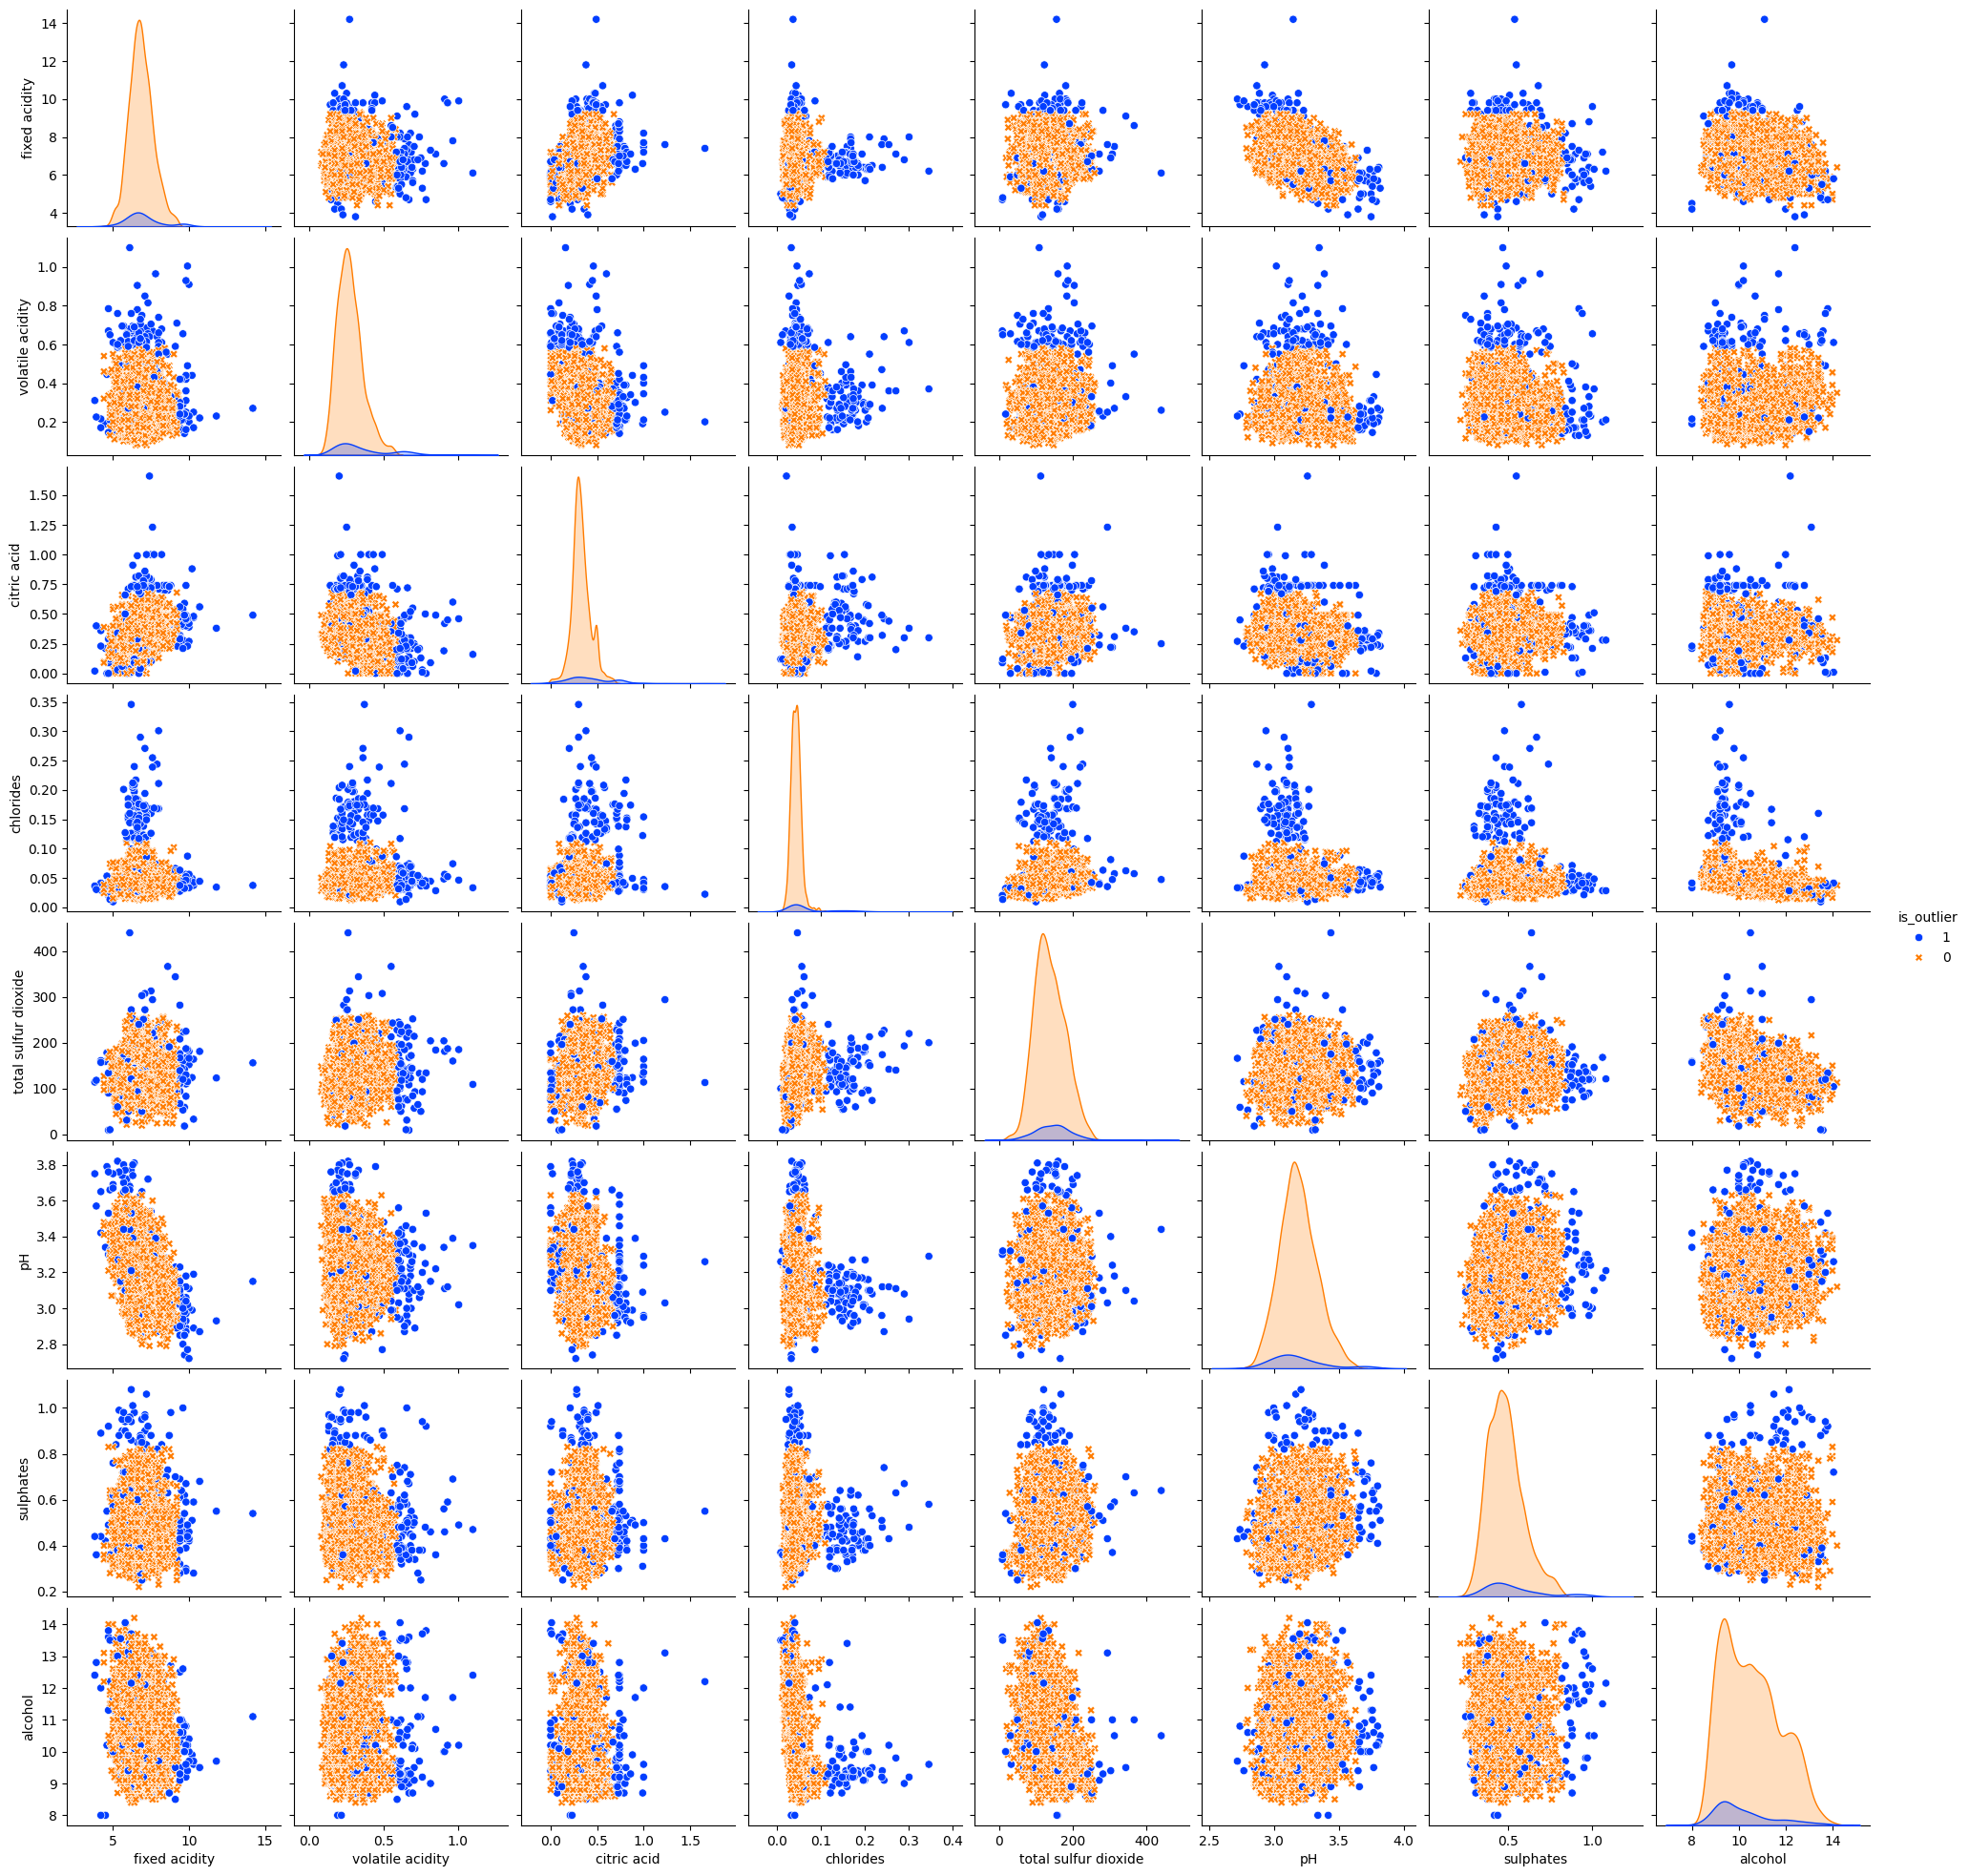

In [ ]:
# ~50 sec
labeled_data = data_features.copy()
labeled_data['is_outlier'] = std_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

# Anomaly Detection


`Scikit-learn` has several anomalies detection algorithms. Their description and examples are provided on [this page](https://scikit-learn.org/stable/modules/outlier_detection.html).

<center><img src="https://github.com/darkydash/ml_hse_2024/blob/main/week10/anomaly.png?raw=1" width="500"></center>

## One-class SVM <a id="one-class_svm"></a>

# <center>Unsupervised model-based</center>

## <center>One-Class SVM</center>

## Brielfy about Support Vector Machine

In short, the SVM is a basic linear model. The main idea of the algorithm (in the case of classification) is to divide the classes by a hyperplane so as to maximize the distance (gap) between them. Initially, the algorithm was able to work only with linearly separable classes, but in the 90s of the last century, the method became especially popular due to the introduction of the "Kernel Trick" (1992), which made it possible to work effectively with linearly inseparable data.

![](https://sandipanweb.files.wordpress.com/2018/04/svm_slack.png?w=676)

## Kernel Trick

The kernel is a function that can transform the feature space (including non-linearly), without directly transforming the features.

It is extremely efficient in terms of calculation and potentially allows you to obtain infinite-dimensional feature spaces.

The idea is that classes that are linearly inseparable in the current feature space can become separable in higher-dimensional spaces:

![](https://miro.medium.com/max/1838/1*eU9PzjVcLNbNEzBC2g_iWg.jpeg)

## One Class SVM
Good [article](https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html) with explanation.

**One Class SVM** - this is one of the forms of the classical algorithm, but, as the name implies, to train it, we only need to have one class, even if it is a little "noisy", and we want to learn how to make a decision for each new observation, whether it is anomalous or not.

**General Idea:** transform the feature space and draw the separating hyperplane so that the observations lie as far away from the origin as possible:

![](https://www.researchgate.net/profile/Hany_Alashwal/publication/242572058/figure/fig1/AS:393295319584771@1470780319210/Classification-in-one-class-SVM.png)

As a result, we get a boundary on one side of which lie the most "dense" and similar observations from our training sample, and on the other side there will be anomalous values that are not similar to all the others. The percentage of such anomalous observations that the model will try to separate from the main part of the sample, we again set at the very beginning of training using the parameter `nu`

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features),
    columns=data_features.columns
)

In [ ]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.10, gamma='auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

In [ ]:
anomalies_report(svm_outliers)

Total number of outliers: 499
Percentage of outliers:   10.19%


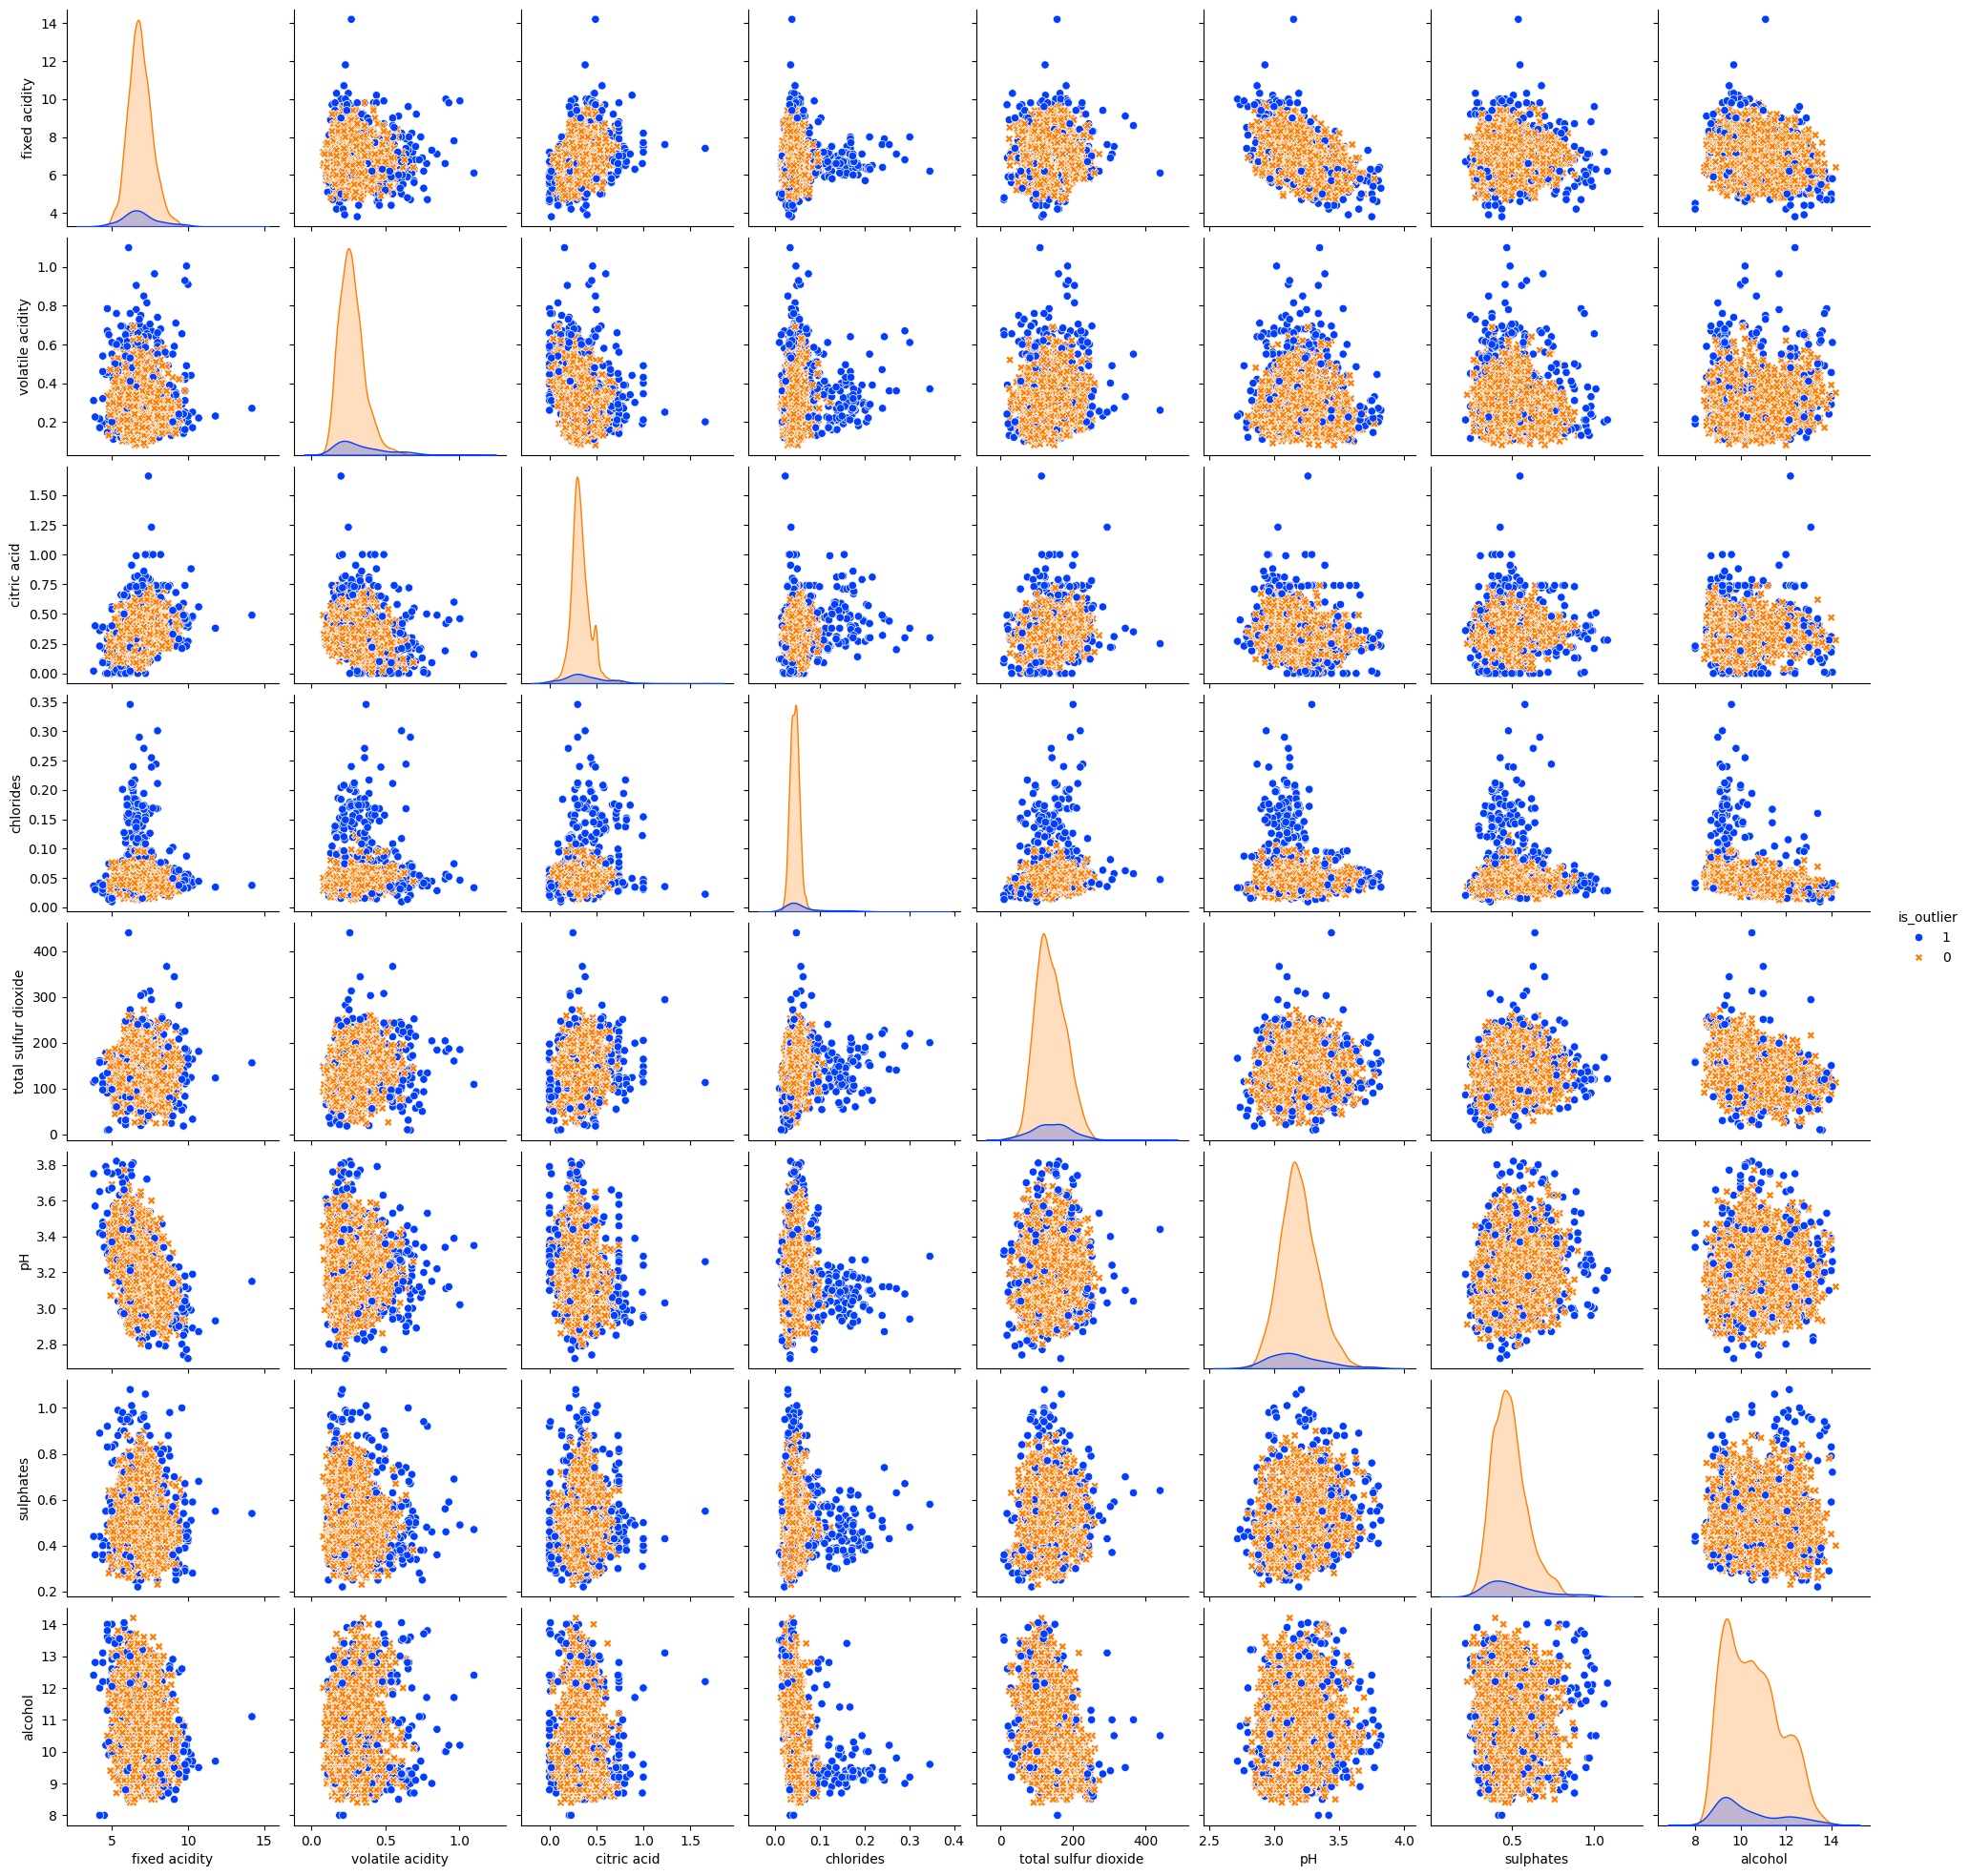

In [ ]:
# ~51 sec
labeled_data = data_features.copy()
labeled_data['is_outlier'] = svm_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

## Pros and cons

\+ Due to kernel trick, the model is able to draw **non-linear dividing boundaries**

\+ It is especially convenient to use when there are not enough "bad" observations in the data to use the standard approach of teaching with a teacher - binary classification

\- It can be very **over-trained** and produce a large number of false negative results if the separation gap is too small

## Isolation Forest <a id="isolation_forest"></a>

## <center> Isolation Forest </center>

The idea - let's see how easy it is to "isolate" an observation from everyone else. If it is too easy, it probably lies far away and is an outlier. If it is very heavy - most likely it is similar to a bunch of other points and is not an outlier.


**Algorithm:**
1. Select the point to isolate.
2. For each feature, set the isolation range between minimum and maximum.
3. Select a feature at random.
4. Select a value that is in the range, again randomly:
    - If the point is higher than the selected value, move the minimum range of the feature by this value.
    - If the point is lower, move the maximum value of the feature by the value.
5. Repeat steps 3 and 4 until the point is isolated. That is, until the point becomes the only one located within the range for all the features.
6. Count the number of times you had to repeat steps 3 and 4.

Good [article](https://quantdare.com/isolation-forest-algorithm/) with explanation.

In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination=0.1,
                                   max_features=1.0, bootstrap=True)
isolation_forest.fit(scaled_data)

isolation_outliers = isolation_forest.predict(scaled_data)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

In [ ]:
anomalies_report(isolation_outliers)

Total number of outliers: 490
Percentage of outliers:   10.00%


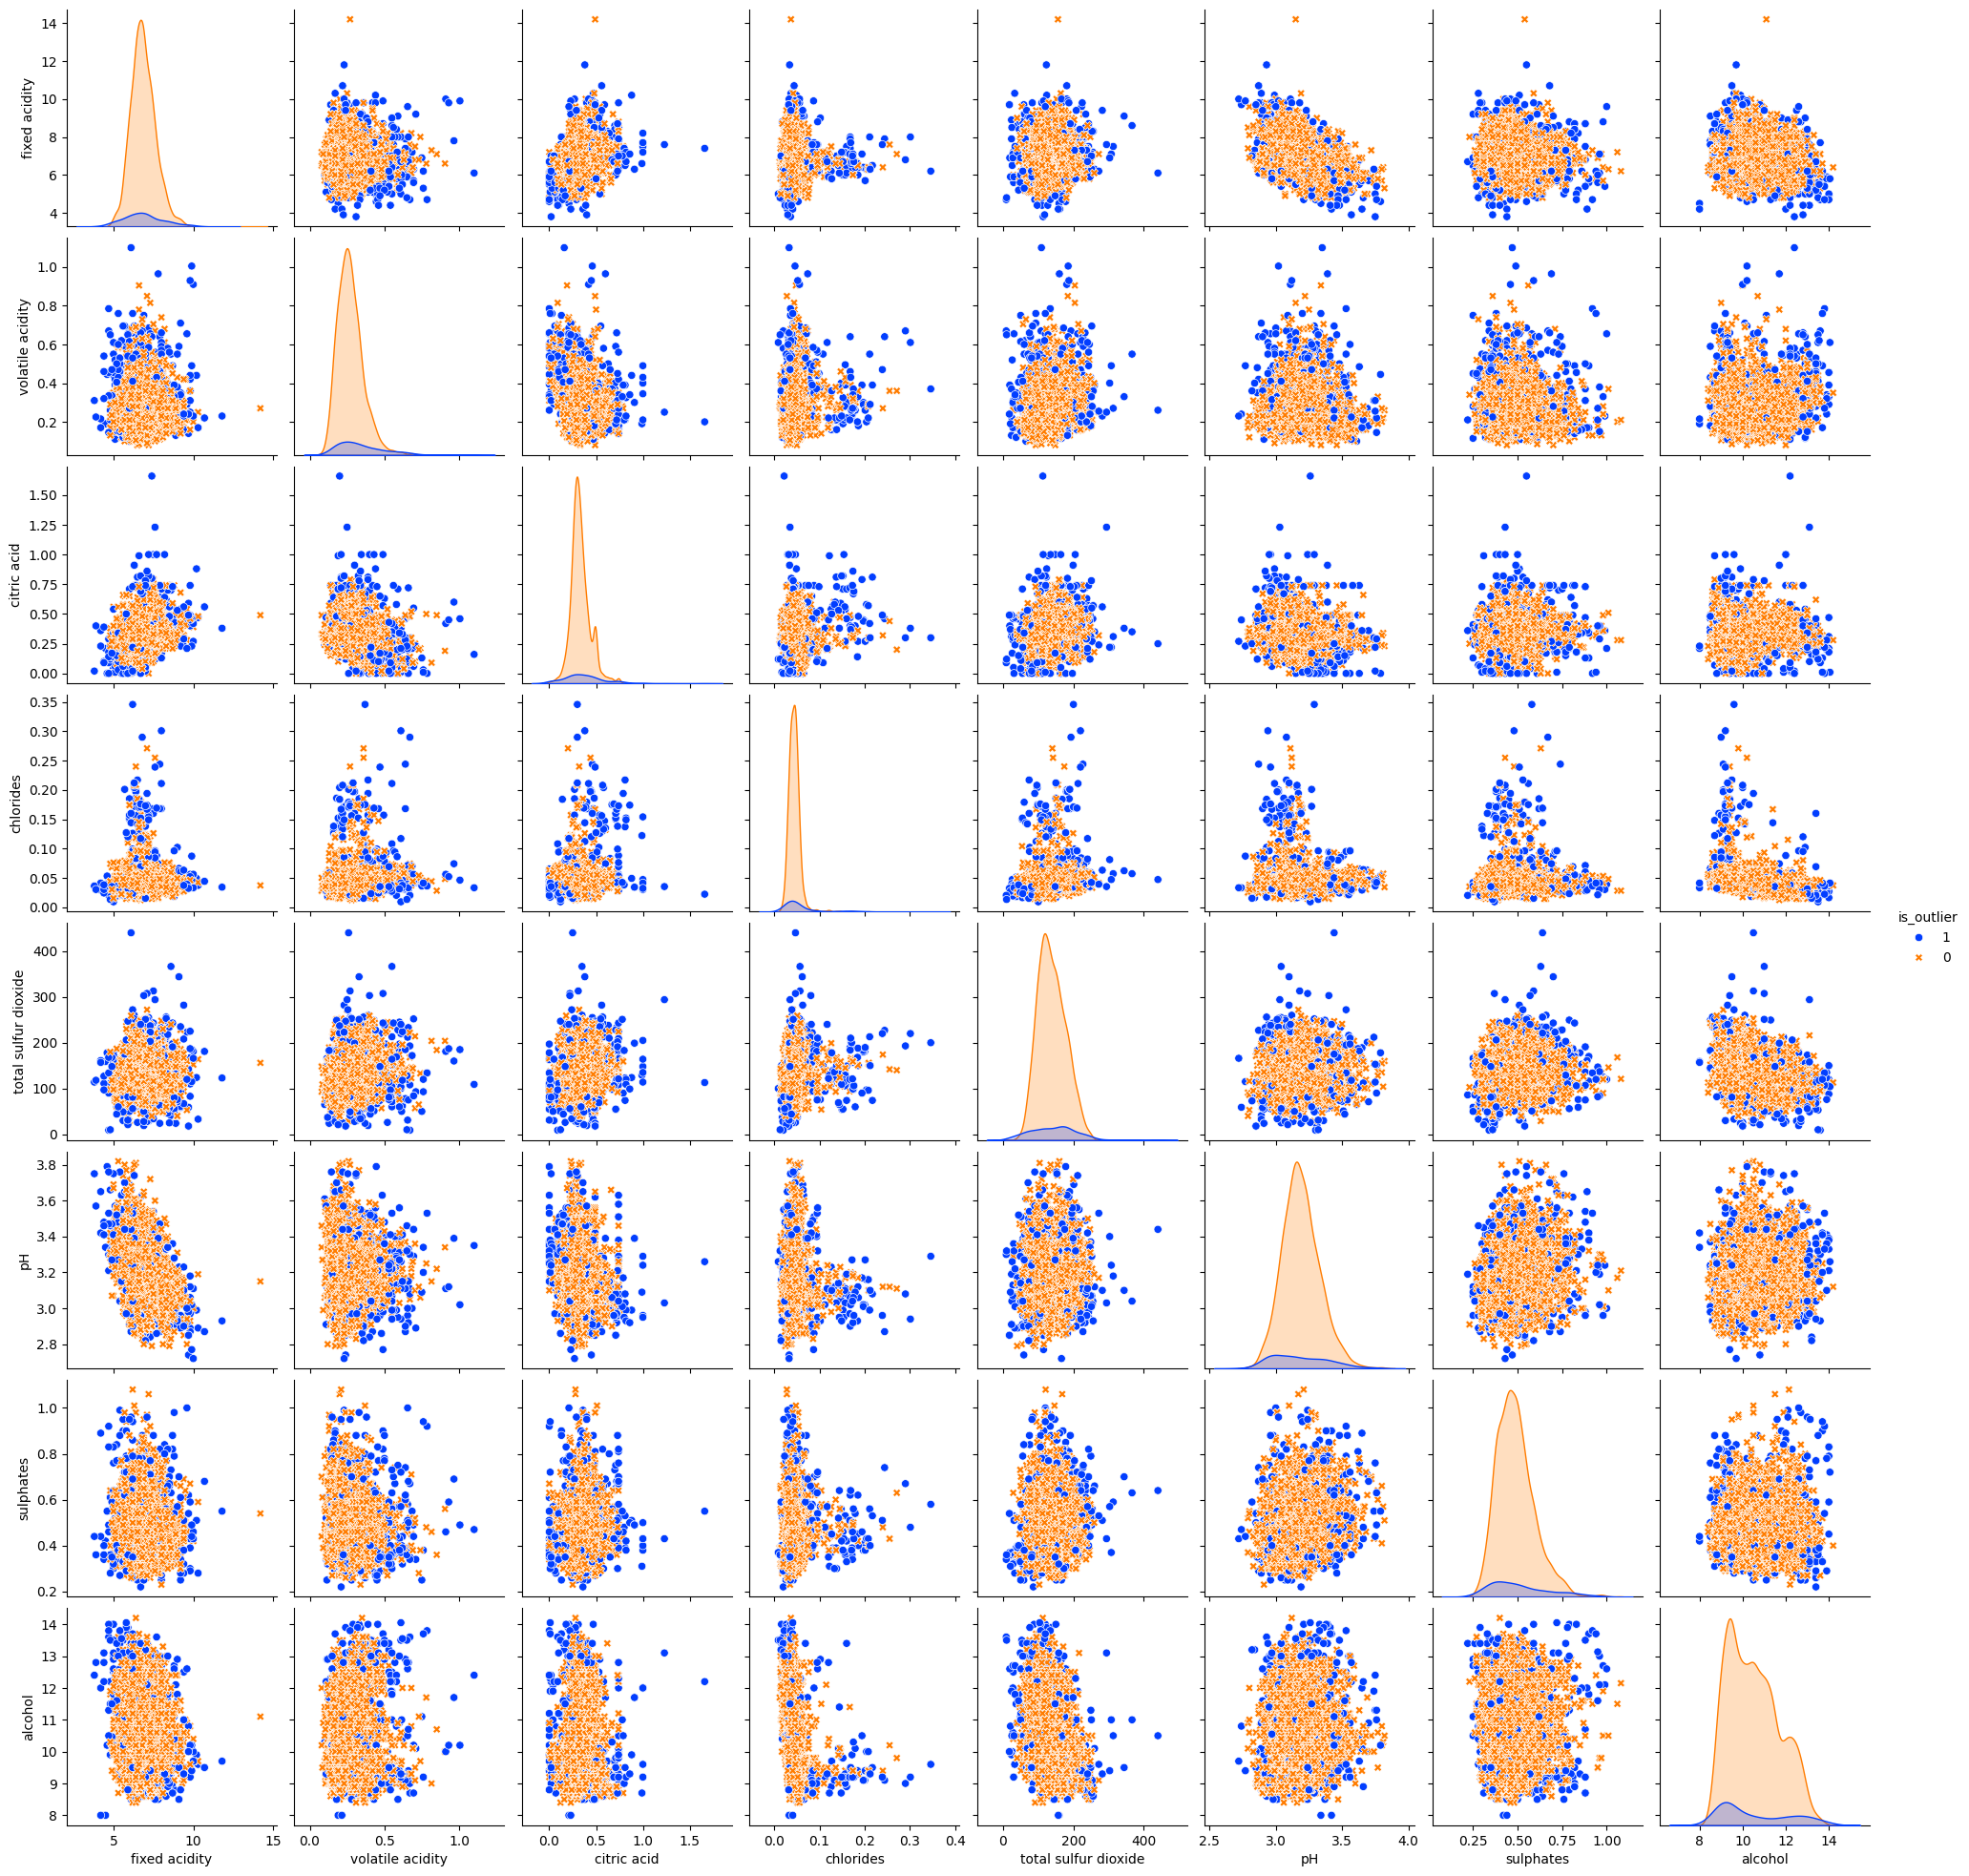

In [ ]:
# ~50 sec
labeled_data = data_features.copy()
labeled_data['is_outlier'] = isolation_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

## Pros and cons

\+ Again **non-linear separating boundaries**, intuitive working principles

\+ Again, it is convenient to use when we can not enter the binary classification

\- A rather complex parameter setting, which is difficult to carry out without at least a minimal markup or an assumption about the number of "dirty" observations-the `contamination`parameter

## CUSUM <a id="cumsum"></a>

[Change detection](http://en.wikipedia.org/wiki/Change_detection) refers to procedures to identify abrupt changes in a phenomenon (Basseville and Nikiforov 1993, Gustafsson 2000). By abrupt change it is meant any difference in relation to previous known data faster than expected of some characteristic of the data such as amplitude, mean, variance, frequency, etc.

The [Cumulative sum (CUSUM)](http://en.wikipedia.org/wiki/CUSUM) algorithm is a classical technique for monitoring change detection. One form of implementing the CUSUM algorithm involves the calculation of the cumulative sum of positive and negative changes ($g_t^+$ and $g_t^-$) in the data ($x$) and comparison to a $threshold$. When this threshold is exceeded a change is detected ($t_{talarm}$) and the cumulative sum restarts from zero. To avoid the detection of a change in absence of an actual change or a slow drift, this algorithm also depends on a parameter $drift$ for drift correction. This form of the CUSUM algorithm is given by:

$$ \begin{array}{l l}
\left\{ \begin{array}{l l}
s[t] = x[t] - x[t-1] \\
g^+[t] = max\left(g^+[t-1] + s[t]-drift,\; 0\right) \\
g^-[t] = max\left(g^-[t-1] - s[t]-drift,\; 0\right)
\end{array} \right. \\
\\
\; if \;\;\; g^+[t] > threshold \;\;\; or \;\;\;  g^-[t] > threshold: \\
\\
\left\{ \begin{array}{l l}
t_{talarm}=t \\
g^+[t] = 0 \\
g^-[t] = 0
\end{array} \right.
\end{array} $$

<!-- TEASER_END -->

There are different implementations of the CUSUM algorithm; for example, the term for the sum of the last elements ($s[t]$ above) can have a longer history (with filtering), it can be normalized by removing the data mean and then divided by the data variance), or this sum term can be squared for detecting both variance and parameter changes, etc.

For the CUSUM algorithm to work properly, it depends on tuning the parameters $h$ and $v$ to what is meant by a change in the data. According to Gustafsson (2000), this tuning can be performed following these steps:

 - Start with a very large $threshold$.  
 - Choose $drift$ to one half of the expected change, or adjust $drift$ such that $g$ = 0 more than 50% of the time.  
 - Then set the $threshold$ so the required number of false alarms (this can be done automatically) or delay for detection is obtained.  
 - If faster detection is sought, try to decrease $drift$.  
 - If fewer false alarms are wanted, try to increase $drift$.   
 - If there is a subset of the change times that does not make sense, try to increase $drift$.

In [ ]:
!pip install detecta

The function `detect_cusum.py` from Python module `detecta` implements the CUSUM algorithm and a procedure to calculate the ending of the detected change. The function signature is:   

```python
ta, tai, taf, amp = detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None)
```   

Let's see how to use `detect_cusum.py`; first let's import the necessary Python libraries and configure the environment:

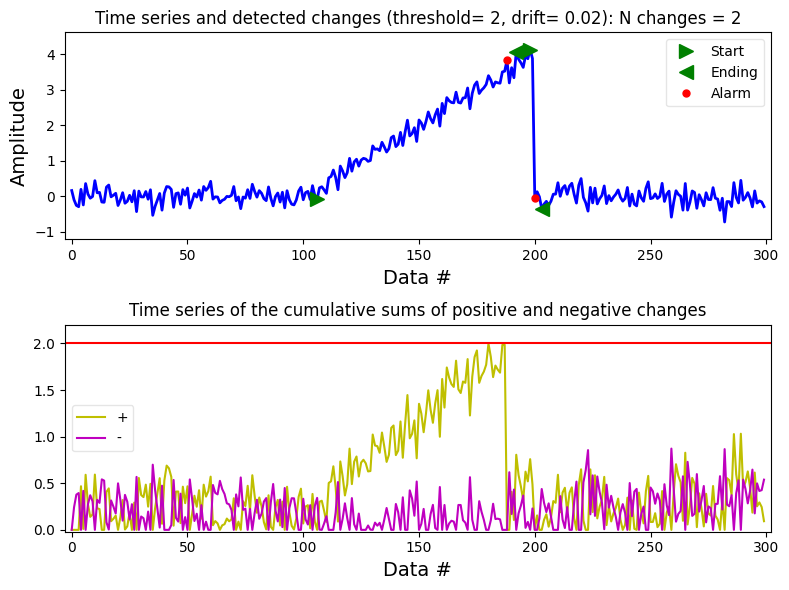

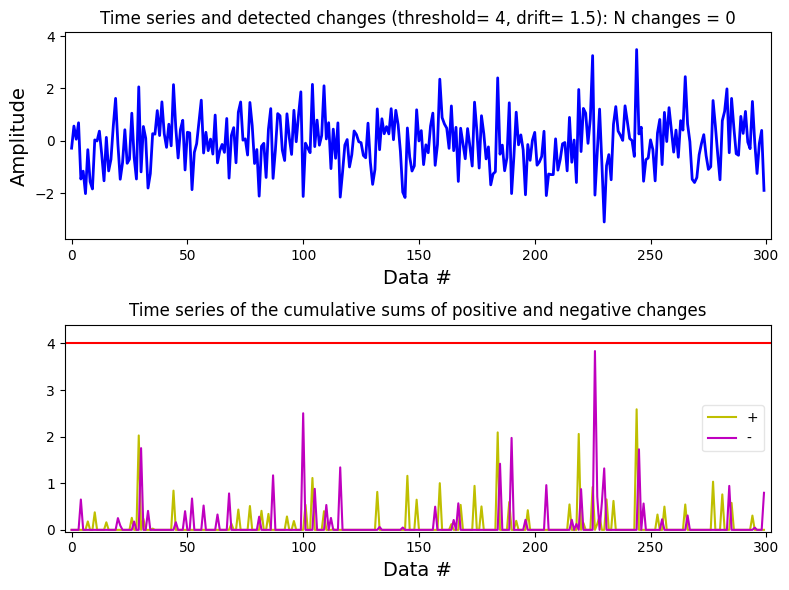

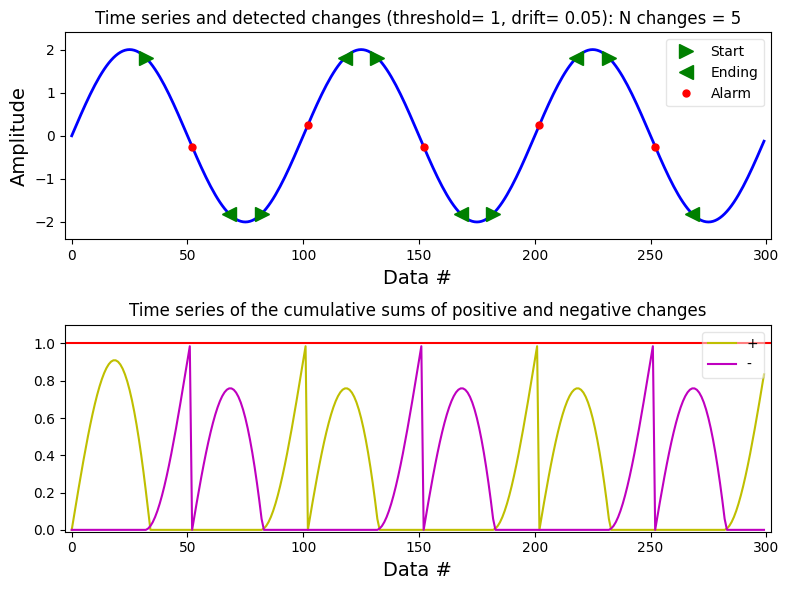

In [ ]:
from detecta import detect_cusum

x = np.random.randn(300)/5
x[100:200] += np.arange(0, 4, 4/100)
ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

x = np.random.randn(300)
detect_cusum(x, 4, 1.5, True, True)

x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)

## Function performance

Here is a poor test of the `detect_cusum.py` performance:

In [ ]:
x = np.random.randn(10000)
x[400:600] += 6
print('Detection of onset (data size = %d):' %x.size)
%timeit detect_cusum(x, 4, 1.5, True, False)

Detection of onset (data size = 10000):
96 ms ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## References

- Michèle Basseville and Igor V. Nikiforov (1993). [Detection of Abrupt Changes: Theory and Application](http://books.google.com.br/books/about/Detection_of_abrupt_changes.html?id=Vu5SAAAAMAAJ). Prentice-Hall.   
- Fredrik Gustafsson (2000) [Adaptive Filtering and Change Detection](http://books.google.com.br/books?id=cyNTAAAAMAAJ). Wiley.

## k-Means <a id="k-means"></a>

K-means clustering is a simple and elegant approach for partitioning a data set into $K$ distinct, non-overlapping clusters. To perform K-means clustering, we must first specify the desired number of clusters K; then the K-means algorithm will assign each observation to exactly one of the $K$ clusters.


We begin by defining some notation. Let $C_1, ..., C_K$ denote sets containing the indices of the observations in each cluster. These sets satisfy two properties:
1. Each observation belongs to at least one of the K clusters.
2. The clusters are nonoverlapping: no observation belongs to more than one cluster.


The idea behind K-means clustering is that a good clustering is one for which the within-cluster variation is as small as possible. The within-cluster variation for cluster $C_k$ is a measure $W(C_k)$ of the amount by which the observations
within a cluster differ from each other. Hence we want to solve the problem $$\sum_{k=1}^K W(C_k) \to \min_{C_k}.$$ In words, this formula says that we want to partition the observations into $K$ clusters such that the total within-cluster variation, summed over all $K$ clusters, is as small as possible.

In order to make it actionable we need to define the within-cluster variation. There are many possible ways to define this concept, but by far the most common choice involves squared Euclidean distance. That is, we define $$W(C_k) = \frac{1}{|C_k|}\sum_{i,i'\in C_k}\sum_{j=1}^p\left(x_{ij}-x_{i'j}\right)^2.$$ In other words, the within-cluster variation for the kth cluster is the sum of all of the pairwise squared Euclidean distances between the observations in the k-th cluster, divided by the total number of observations in the k-th cluster.

### Data preparation

In [ ]:
n_samples = 1500
random_state = 170

#toy datasets
X_blobs, y_blobs = datasets.make_blobs(centers=3, n_samples=n_samples, random_state=random_state, center_box=(-10, 10))
X_circles, y_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
X_moons, y_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

In [ ]:
X_blobs[:5], X_circles[:5], X_moons[:5]

(array([[ -5.19811282,   0.64186932],
        [ -5.75229538,   0.41862711],
        [-10.84489837,  -7.55352273],
        [ -4.57098483,  -0.80101741],
        [ -3.51916215,   0.0393449 ]]),
 array([[ 0.43194573,  0.1621333 ],
        [ 0.26461964, -0.4603757 ],
        [ 0.4529587 , -0.07117732],
        [-0.39501279, -0.27039313],
        [-0.07004995,  0.56442577]]),
 array([[ 1.59713261, -0.36268687],
        [ 0.99917367, -0.59829527],
        [ 1.47334438, -0.51413813],
        [ 0.75752729,  0.48890662],
        [ 1.01562369, -0.55082053]]))

In [ ]:
y_blobs[:10]

array([1, 1, 0, 1, 1, 2, 0, 0, 0, 2])

In [ ]:
def plot_clusters(X, y):

    # Create an figure with a custom size
    # plt.figure(figsize=(6, 4))

    if y is not None:
        for cluster_label in np.unique(y):
            # Plot all objects with y == i (class 0)
            plt.scatter(X[y == cluster_label, 0],     # selects all objects with y == i and the 1st column of X
                        X[y == cluster_label, 1],     # selects all objects with y == i and the 2nd column of X
                        label=str(cluster_label))     # label for the plot legend
    else:
        plt.scatter(X[:, 0], X[:, 1], label='samples')

    plt.xlabel('X1', size=12) # set up X-axis label
    plt.ylabel('X2', size=12) # set up Y-axis label
    plt.xticks(size=12)
    plt.yticks(size=12)

    plt.legend(loc='best', fontsize=12) # create the plot legend and set up it position
    plt.grid() # create grid on the plot

    plt.show() # display the plot

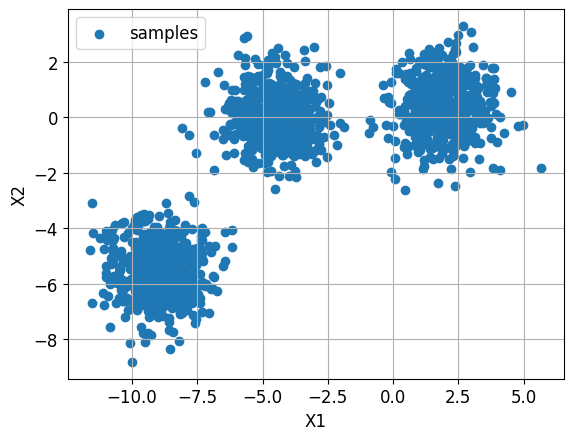

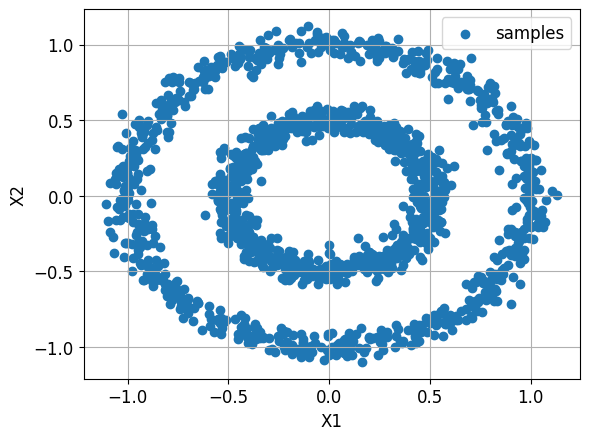

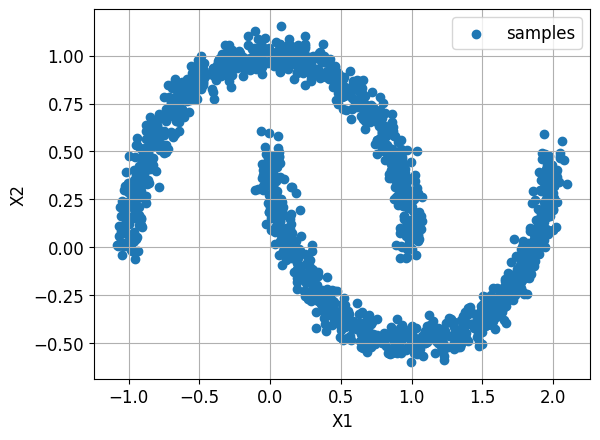

In [ ]:
plot_clusters(X_blobs, y=None)
plot_clusters(X_circles, y=None)
plot_clusters(X_moons, y=None)

### K-Means algorithm:

In [ ]:
#sklearn kmeans implementation
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, max_iter=20, n_init=10)
kmeans.fit(X_blobs)
y_pred_blobs = kmeans.predict(X_blobs)

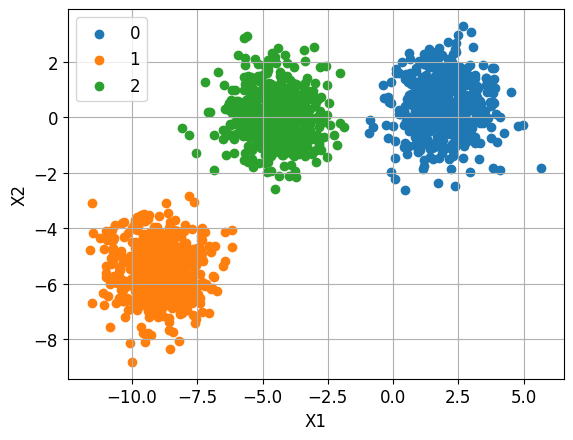

In [ ]:
plot_clusters(X_blobs, y_pred_blobs)

In [ ]:
kmeans = KMeans(n_clusters=2, max_iter=20, n_init=10)
kmeans.fit(X_circles)
y_pred_circles = kmeans.predict(X_circles)

kmeans = KMeans(n_clusters=2, max_iter=20, n_init=10)
kmeans.fit(X_moons)
y_pred_moons = kmeans.predict(X_moons)

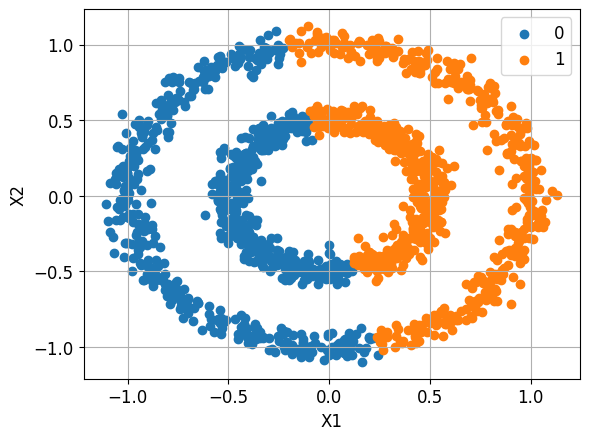

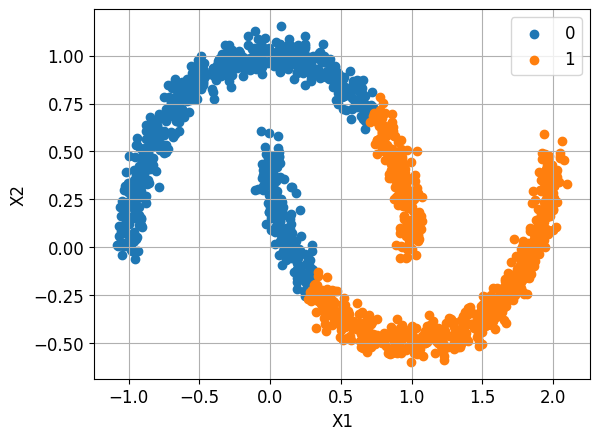

In [ ]:
plot_clusters(X_circles, y_pred_circles)
plot_clusters(X_moons, y_pred_moons)

K-means doesn't work well here in this example. We need to use some other clustering algorithm here. Which one?

## Metrics

**Silhouette Score:**

$$
s = \frac{b - a}{max(a, b)}
$$

- **a**: The mean distance between a sample and all other points in the same class.
- **b**: The mean distance between a sample and all other points in the next nearest cluster.

Silhouette Score for the dataset is the average computed as the average for all the examples.


**Adjusted Rand Index (ARI):**

$$
ARI = \frac{RI - Expected\_RI}{max(RI) - Expected\_RI}
$$

$$
RI = \frac{a + b}{a + b + c + d}
$$


- a, the number of pairs of elements in S that are in the same subset in X and in the same subset in Y
- b, the number of pairs of elements in S that are in different subsets in X and in different subsets in Y
- c, the number of pairs of elements in S that are in the same subset in X and in different subsets in Y
- d, the number of pairs of elements in S that are in different subsets in X and in the same subset in Y

In [ ]:
from sklearn import metrics

silhouette_score_values = []
adjusted_rand_score_values = []
n_clusters = np.arange(2, 21)

for n in n_clusters:

    clusterer = KMeans(n_clusters=n, max_iter=10, n_init=10)
    clusterer.fit(X_blobs)
    y_pred = clusterer.predict(X_blobs)

    score1 = metrics.silhouette_score(X_blobs, y_pred)
    silhouette_score_values.append(score1)

    score2 = metrics.adjusted_rand_score(y_blobs, y_pred)
    adjusted_rand_score_values.append(score2)

In [ ]:
y_blobs

array([1, 1, 0, ..., 2, 2, 2])

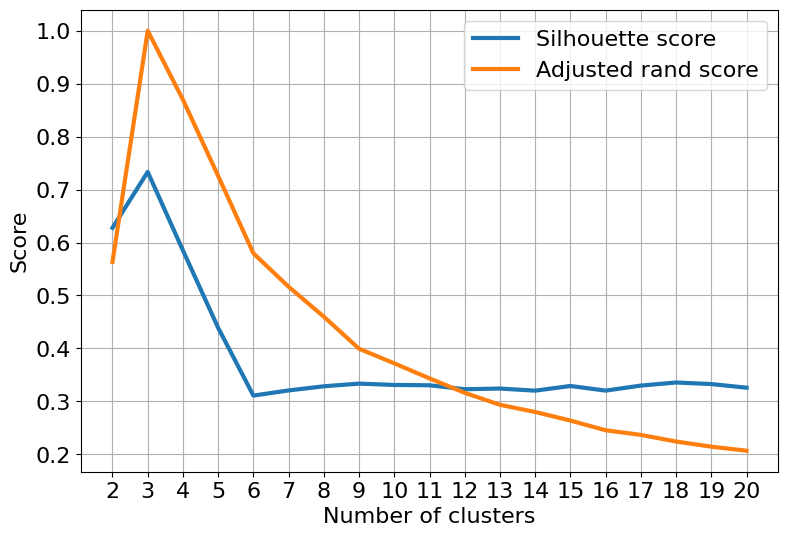

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(n_clusters, silhouette_score_values, linewidth=3, label='Silhouette score')
plt.plot(n_clusters, adjusted_rand_score_values, linewidth=3, label='Adjusted rand score')
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Score', size=16)
plt.xticks(n_clusters, size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

## DBSCAN <a id="dbscan"></a>


DBSCAN algorithm:
- 1. Select a random point and find its neighbors in the given
neighborhood
- 2. If the neighbors are less than the critical value, we call them outliers
- 3. If not, combine it into a "dense" cluster and repeat the search for neighbors
- 4. If all dense points are passed and marked as visited-select a new point that is not visited and start over

Cool visualisation of DBSCAN is [here](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/).

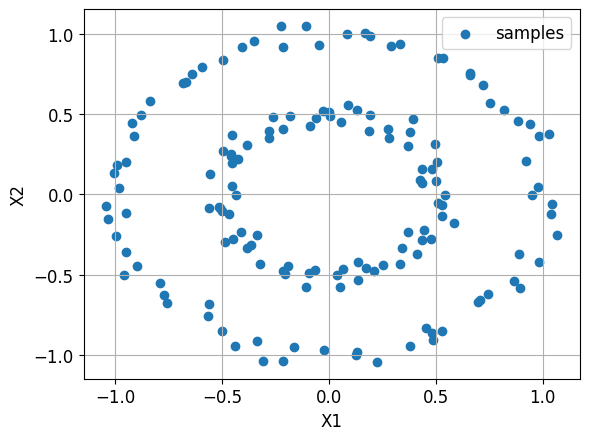

In [ ]:
from sklearn import datasets

n_samples = 150
random_state = 170
#X, y = datasets.make_blobs(centers=3, n_samples=n_samples, random_state=random_state, center_box=(-10, 10))

# To play with
X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
# X, y = datasets.make_moons(n_samples=n_samples, noise=.05)
# X = np.random.rand(n_samples, 2)

plot_clusters(X, None)

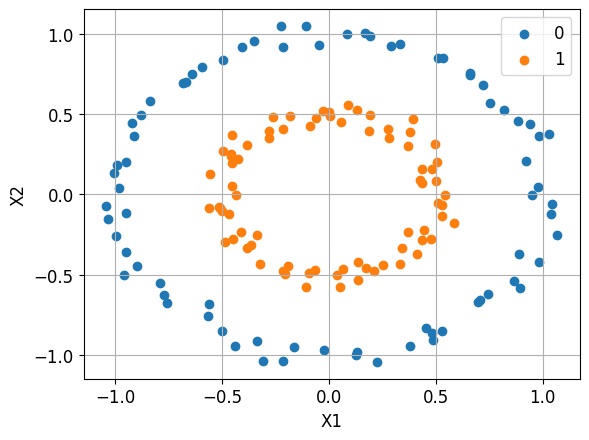

In [ ]:
# DBSCAN
from sklearn import cluster

# Run clusterer
clusterer = cluster.DBSCAN(eps=0.25, min_samples=5)
y_pred = clusterer.fit_predict(X)

# Plot clustering results
plot_clusters(X, y_pred)

How to select parameters of DBSCAN algorithm properly?

In [ ]:
from sklearn.neighbors import NearestNeighbors

k = 5

# estimate k neighbors for each point in X
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)

# calculate distances for each of k nearest neighbors
dists, _ = nn.kneighbors(X, n_neighbors=k)

# take distaces only for the k-th neighbors
dist_kth = dists[:, k-1]

# sort the distances
dist_kth.sort()

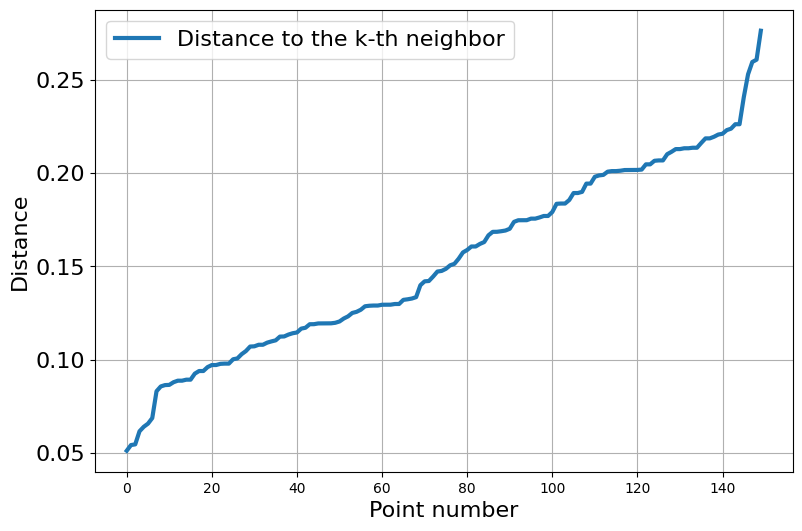

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(dist_kth, linewidth=3, label='Distance to the k-th neighbor')
plt.xlabel('Point number', size=16)
plt.ylabel('Distance', size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

##Hierarchical clustering

Hierarchical clustering is one of the popular and easy to understand clustering technique.

This clustering technique is divided into two types:
1. Agglomerative (the algorithm combines two smaller clusters into one at each iteration)
2. Divisive (the algorithm splits one cluster into two smaller ones at each iteration)

We will consider an agglomerative hierarchical clustering (divisive can be considered by analogy).

**Agglomerative Hierarchical clustering Technique:**
In this technique, initially each data point is considered as an individual cluster. At each iteration, the similar clusters merge with other clusters until one cluster or K clusters are formed.

The basic algorithm of Agglomerative is straight forward.
1. Compute the proximity matrix
2. Let each data point be a cluster
3. **Repeat:** Merge the two closest clusters and update the proximity matrix
4. Until only a single cluster remains

Resume:
1. We can select any number of clusters stopping the algorithm when we need
2. This algorithm is much less sensitive to the choice of metrics between points than other ones

The Hierarchical clustering Technique can be visualized using a Dendrogram.


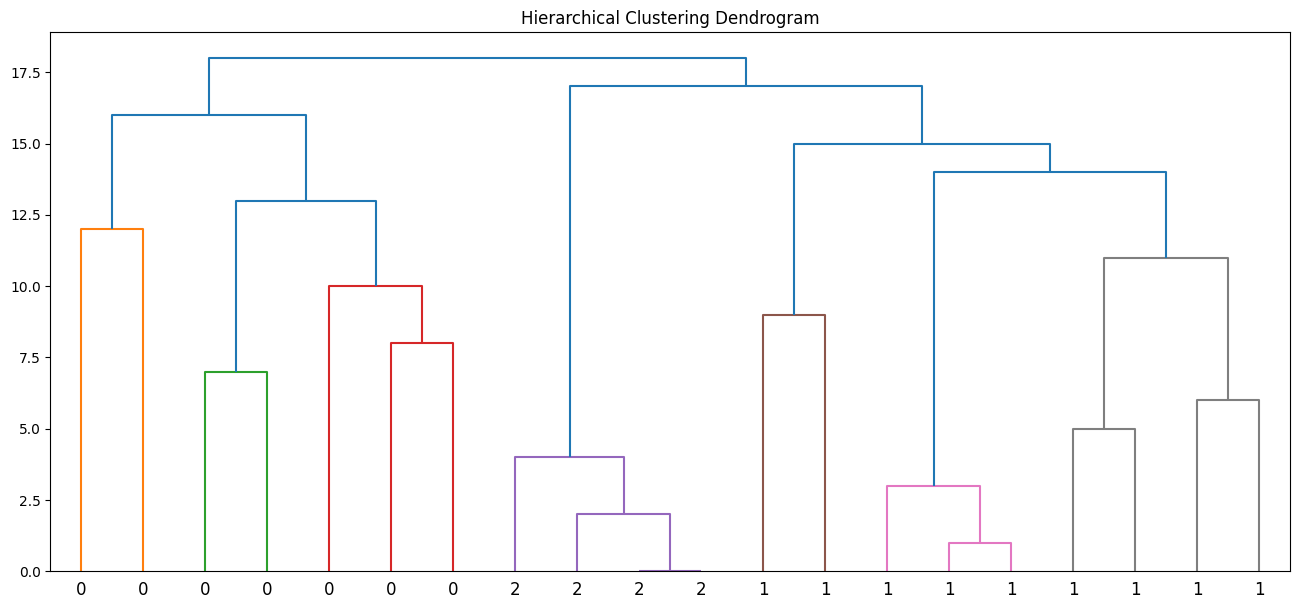

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    # linkage matrix format: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data[:20]
model = AgglomerativeClustering(n_clusters=3)

model = model.fit(X)
plt.figure(figsize=(16,7))
plot_dendrogram(model, labels=model.labels_)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()